### **Types**

In [260]:
from dataclasses import dataclass
from typing import List
import random

In [261]:
@dataclass
class PhysicalNode:
    internal_id: int
    external_id: int
    domain_id: int

    resource: float
    used_resource: float
    cost_per_unit: float
    delay: float

    @staticmethod
    def generator(external_id: int, internal_id: int, domain_id: int):
        return PhysicalNode(
            external_id=external_id,
            internal_id=internal_id,
            domain_id=domain_id,

            resource=random.uniform(100, 300),
            used_resource=0,
            cost_per_unit=random.uniform(1, 10),
            delay=random.uniform(1, 10)
        )

In [262]:
@dataclass
class PhysicalLink:
    src: PhysicalNode
    dest: PhysicalNode

    bandwidth: float
    used_bandwidth: float
    cost_per_unit: float
    delay: float

    @staticmethod
    def generator(source: PhysicalNode, dest: PhysicalNode):
        return PhysicalLink(
            src=source,
            dest=dest,
            bandwidth = random.uniform(1000, 3000),
            used_bandwidth=0,
            cost_per_unit = random.uniform(1, 10),
            delay = random.uniform(1, 10)
        )

In [263]:
import math
from dataclasses import dataclass, field
from typing import List, Optional

@dataclass
class PhysicalDomain:
    id: int
    nodes: List["PhysicalNode"]
    boundary_nodes: List["PhysicalNode"]
    intra_links: List[List[Optional["PhysicalLink"]]]
    inter_links: List["PhysicalLink"]

    dist: List[List[float]] = field(default_factory=list)
    next_node: List[List[Optional[int]]] = field(default_factory=list)

    @staticmethod
    def generator(num_of_nodes: int, number_of_boundary_nodes: int, domain_id: int, connection_rate: float):
        nodes = [
            PhysicalNode.generator(
                external_id=0,
                internal_id=i,
                domain_id=domain_id
            ) for i in range(num_of_nodes)
        ]
        
        intra_links = [[None for _ in range(num_of_nodes)] for _ in range(num_of_nodes)]

        for i in range(num_of_nodes):
            for j in range(i + 1, num_of_nodes):
                if random.random() <= connection_rate:
                    link = PhysicalLink.generator(nodes[i], nodes[j])
                    intra_links[i][j] = intra_links[j][i] = link

        boundary_nodes = random.choices(nodes, k=number_of_boundary_nodes)

        domain = PhysicalDomain(
            id=domain_id,
            nodes=nodes,
            boundary_nodes=boundary_nodes,
            intra_links=intra_links,
            inter_links=[]
        )

        domain.compute_shortest_paths()
        return domain

    def add_inter_links(self, link: "PhysicalLink"):
        self.inter_links.append(link)
    
    def calculate_weight(self, cost: float, delay: float):
        return 0.9*cost + 0.1*delay

    def compute_shortest_paths(self):
        n = len(self.nodes)
        self.dist = [[math.inf] * n for _ in range(n)]
        self.next_node = [[None] * n for _ in range(n)]

        for i in range(n):
            self.dist[i][i] = 0
            for j in range(n):
                link = self.intra_links[i][j]
                if link:
                    weight = self.calculate_weight(cost=link.cost_per_unit, delay=link.delay)
                    self.dist[i][j] = weight
                    self.next_node[i][j] = j

        for k in range(n):
            for i in range(n):
                for j in range(n):
                    if self.dist[i][k] + self.dist[k][j] < self.dist[i][j]:
                        self.dist[i][j] = self.dist[i][k] + self.dist[k][j]
                        self.next_node[i][j] = self.next_node[i][k]

    def shortest_path(self, src_id: int, dest_id: int):
        if not self.next_node or self.next_node[src_id][dest_id] is None:
            return []
        path = [src_id]
        while src_id != dest_id:
            src_id = self.next_node[src_id][dest_id]
            path.append(src_id)
        return path

    def shortest_distance(self, src_id: int, dest_id: int) -> float:
        if not self.dist:
            raise ValueError("Shortest paths not computed yet.")
        return self.dist[src_id][dest_id]


In [264]:
from dataclasses import dataclass
from typing import List
import random

@dataclass
class PhysicalNetwork:
    domains: List[PhysicalDomain]
    inter_links: List[PhysicalLink]

    @staticmethod
    def generator(num_domains: int, nodes_per_domain: int, boundary_nodes_per_domain: int, connection_rate: float):
        domains = []
        inter_links = []
        global_node_id = 0

        for domain_id in range(num_domains):
            domain = PhysicalDomain.generator(
                num_of_nodes=nodes_per_domain,
                number_of_boundary_nodes=boundary_nodes_per_domain,
                domain_id=domain_id,
                connection_rate=connection_rate
            )
            
            for node in domain.nodes:
                node.external_id = global_node_id
                global_node_id += 1

            domains.append(domain)

        for i in range(num_domains):
            for j in range(i + 1, num_domains):
                src = random.choice(domains[i].boundary_nodes)
                dest = random.choice(domains[j].boundary_nodes)

                link = PhysicalLink.generator(src, dest)
                inter_links.append(link)

                domains[i].add_inter_links(link)
                domains[j].add_inter_links(PhysicalLink(
                    src=link.dest,
                    dest=link.src,
                    bandwidth=link.bandwidth,
                    used_bandwidth=0,
                    cost_per_unit=link.cost_per_unit,
                    delay=link.delay
                ))

        return PhysicalNetwork(
            domains=domains,
            inter_links=inter_links
        )

In [265]:

@dataclass
class VirtualNode:
    id: int
    resource: float
    candidate_domains: List[int]

    @staticmethod
    def generator(node_id: int, num_candidates: int, num_domains: int):
        return VirtualNode(
            id=node_id,
            resource=random.uniform(1, 10),
            candidate_domains=random.sample(range(num_domains), k=random.randint(1, num_domains - 1))
        )


In [266]:
@dataclass
class VirtualLink:
    src: VirtualNode
    dest: VirtualNode
    bandwidth: float

    @staticmethod
    def generator(src: VirtualNode, dest: VirtualNode):
        return VirtualLink(
            src=src,
            dest=dest,
            bandwidth=random.uniform(1, 10)
        )

In [267]:
from dataclasses import dataclass
from typing import List
import random

@dataclass
class VirtualNetwork:
    nodes: List[VirtualNode]
    links: List[List[VirtualLink]] 

    @staticmethod
    def generator(num_nodes: int, connection_rate: float, number_of_domains: int):
        nodes = [
            VirtualNode.generator(i, number_of_domains, number_of_domains)
            for i in range(num_nodes)
        ]

        links = [[None for _ in range(num_nodes)] for _ in range(num_nodes)]

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                if random.random() <= connection_rate:
                    links[i][j] = VirtualLink.generator(nodes[i], nodes[j])
                    links[j][i] = VirtualLink(
                        src=nodes[j],
                        dest=nodes[i],
                        bandwidth=links[i][j].bandwidth
                    )

        return VirtualNetwork(
            nodes=nodes,
            links=links
        )

In [268]:
import math
from typing import Dict, List, Tuple

class PhysicalNetworkEvaluator:
    def __init__(self, physical_network: PhysicalNetwork):
        self.physical_network = physical_network
        self.dist = None
        self.next_node = None
        self.network: List[List[PhysicalLink]] = None
        self.floy_d_shortest_path()

    def _get_all_nodes(self):
        return [n for d in self.physical_network.domains for n in d.nodes]

    def _build_global_graph(self):
        all_nodes = self._get_all_nodes()
        n = len(all_nodes)
        dist = [[math.inf] * n for _ in range(n)]
        next_node = [[None] * n for _ in range(n)]
        network:List[List[PhysicalLink]] = [[None]*n for _ in range(n)]

        for i in range(n):
            dist[i][i] = 0

        def add_link(link: PhysicalLink):
            u = link.src.external_id
            v = link.dest.external_id
            w = link.cost_per_unit
            network[u][v] = network[v][u] = link

            if w < dist[u][v]:
                dist[u][v] = dist[v][u] = w
                next_node[u][v] = v
                next_node[v][u] = u

        for d in self.physical_network.domains:
            for row in d.intra_links:
                for link in row:
                    if link:
                        add_link(link)

        for link in self.physical_network.inter_links:
            add_link(link)

        self.dist, self.next_node, self.network = dist, next_node, network

    def floy_d_shortest_path(self):
        if self.dist is None:
            self._build_global_graph()

        n = len(self.dist)
        for k in range(n):
            for i in range(n):
                if self.dist[i][k] == math.inf:
                    continue
                for j in range(n):
                    nd = self.dist[i][k] + self.dist[k][j]
                    if nd < self.dist[i][j]:
                        self.dist[i][j] = nd
                        self.next_node[i][j] = self.next_node[i][k]

    def get_distance(self, src, dest) -> float:
        return self.dist[src.external_id][dest.external_id]

    def get_path(self, src, dest):
        i, j = src.external_id, dest.external_id
        if self.next_node[i][j] is None:
            return []
        path = [src]
        while i != j:
            i = self.next_node[i][j]
            node = self._get_all_nodes()[i]
            path.append(node)
        return path
    
    # Return [cost, delay] id valid, if not return None
    def evaluate_mapping_cost(self, mapping: Dict[int, PhysicalNode], v_network: VirtualNetwork) -> Tuple[float, float] | None:
        total_delay = 0.0
        total_cost = 0.0
        for i in range(len(v_network.nodes)):
            v_src = v_network.nodes[i]
            p_src = mapping[i]

            if v_src.resource > p_src.resource:
                return None

            total_cost += v_src.resource * p_src.cost_per_unit
            total_delay += p_src.delay

            for j in range(i+1, len(v_network.nodes)):
                v_link = v_network.links[i][j]
                if not v_link:
                    continue
                
                p_dst = mapping[j]
                shortest_path:List[PhysicalNode] = self.get_path(p_src, p_dst)

                prev_node = None
                for node in shortest_path:
                    if prev_node:
                        p_link = self.network[prev_node.external_id][node.external_id]
                        remaining_bandwidth = p_link.bandwidth - p_link.used_bandwidth
                        if remaining_bandwidth < v_link.bandwidth:
                            return None

                        total_cost += v_link.bandwidth * p_link.cost_per_unit
                        total_delay += p_link.delay

                    prev_node = node

        return total_delay, total_cost

### **Visualization**

In [269]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_physical_network(network: PhysicalNetwork):
    G = nx.Graph()

    for domain in network.domains:
        for node in domain.nodes:
            G.add_node(
                node.external_id,
                domain=domain.id,
                resource=node.resource,
                cost=node.cost_per_unit,
                delay=node.delay,
            )

    for domain in network.domains:
        for row in domain.intra_links:
            for link in row:
                if link:
                    G.add_edge(
                        link.src.external_id,
                        link.dest.external_id,
                        bandwidth=link.bandwidth,
                        type="intra"
                    )

    for link in network.inter_links:
        G.add_edge(
            link.src.external_id,
            link.dest.external_id,
            bandwidth=link.bandwidth,
            type="inter"
        )

    pos = nx.spring_layout(G, seed=42, k=1.5, iterations=200)
    plt.figure(figsize=(12, 9))

    domain_colors = {d.id: f"C{d.id % 10}" for d in network.domains}

    for domain in network.domains:
        nodes = [n.external_id for n in domain.nodes]
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodes,
            node_color=domain_colors[domain.id],
            label=f"Domain {domain.id}",
            node_size=700
        )

    intra_edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "intra"]
    inter_edges = [(u, v) for u, v, d in G.edges(data=True) if d["type"] == "inter"]

    nx.draw_networkx_edges(G, pos, edgelist=intra_edges, style="solid", width=1.5, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=inter_edges, style="dotted", width=2.2, edge_color="black")

    node_labels = {
        n: f"{n}\n({d['resource']:.1f})"
        for n, d in G.nodes(data=True)
    }
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9)

    edge_labels = {
        (u, v): f"{d['bandwidth']:.1f}"
        for u, v, d in G.edges(data=True)
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Physical Network Visualization")
    plt.legend()
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [270]:
def visualize_virtual_network(virtual_network):
    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.Graph()
    for node in virtual_network.nodes:
        G.add_node(node.id, resource=node.resource)

    for i in range(len(virtual_network.nodes)):
        for j in range(i + 1, len(virtual_network.nodes)):
            link = virtual_network.links[i][j]
            if link:
                G.add_edge(link.src.id, link.dest.id, bandwidth=link.bandwidth)

    pos = nx.spring_layout(G, seed=42, k=1.2, iterations=150)

    node_labels = {
        n: f"{n}\n({d['resource']:.1f})"
        for n, d in G.nodes(data=True)
    }

    edge_labels = {
        (u, v): f"{d['bandwidth']:.1f}"
        for u, v, d in G.edges(data=True)
    }

    plt.figure(figsize=(7, 6))
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_color='skyblue',
        node_size=800,
        edge_color='gray',
        width=1.5
    )
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Virtual Network Visualization")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [271]:
import matplotlib.pyplot as plt
def visualize_array(arr, title, x, y):
    plt.plot(arr, marker='o')
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)
    plt.show()


### **MP_VNE**

In [ ]:
import random
import math
import numpy as np

class MP_VNE:
    def __init__(self, physical_network: PhysicalNetwork):
        self.physical_network = physical_network
        self.mapping_request_usage = {}
        self.evaluator = PhysicalNetworkEvaluator(physical_network=physical_network)

    def select_candidate_nodes(self, v_network: VirtualNetwork) -> List[List[PhysicalNode]]:
        candidate_nodes = [[] for _ in range(len(v_network.nodes))]

        for v_node in v_network.nodes:
            valid_domains = [
                d for d in self.physical_network.domains
                if d.id in v_node.candidate_domains
            ]

            for domain in valid_domains:
                for p_node in domain.nodes:
                    if p_node.resource - p_node.used_resource >= v_node.resource:
                        candidate_nodes[v_node.id].append(p_node)

        return candidate_nodes

    def compute_ckb(self, p_node: PhysicalNode, p_dest: PhysicalNode):
        domain_dict = {d.id: d for d in self.physical_network.domains}
        src_domain = domain_dict[p_node.domain_id]

        dest_domain_id=p_dest.domain_id
        dest_domain = domain_dict[dest_domain_id]

        if src_domain.id == dest_domain.id:
            return src_domain.shortest_distance(p_node.internal_id, p_dest.internal_id)

        boundary_nodes = [
            link.src for link in src_domain.inter_links
            if (link.dest.domain_id == dest_domain.id)
        ]

        if not boundary_nodes or not len(boundary_nodes):
            boundary_nodes = src_domain.boundary_nodes

        if boundary_nodes:
            link_cost = 0
            for b_node in boundary_nodes:
                path_cost = src_domain.shortest_distance(p_node.internal_id, b_node.internal_id)
                link_cost += path_cost
            return link_cost / len(boundary_nodes)

        return math.inf


    def predict_mapping_cost(self, v_network: VirtualNetwork, mapping: List[int], candidate_nodes: List[List[PhysicalNode]]):
        total_cpu_cost = 0
        total_link_cost = 0

        for v_node in v_network.nodes:
            candidate_index = mapping[v_node.id]
            p_node = candidate_nodes[v_node.id][candidate_index]
            cpu_v = v_node.resource

            cost_cpu = cpu_v * p_node.cost_per_unit
            link_cost = 0

            neighbor_links = []
            for j in range(len(v_network.nodes)):
                link = v_network.links[v_node.id][j]
                if link:
                    neighbor_links.append(link)

            for link in neighbor_links:
                bw = link.bandwidth
                v_dest = link.dest

                p_dest = candidate_nodes[v_dest.id][0]
                c_kb = self.compute_ckb(p_node, p_dest)
                link_cost += bw * c_kb

            if len(neighbor_links) > 0:
                total_link_cost += link_cost / len(neighbor_links)

            total_cpu_cost += cost_cpu

        return total_cpu_cost + total_link_cost 

    @staticmethod
    def minus_operation(a, b):
        arr_a = np.array(a)
        arr_b = np.array(b)
        
        return (arr_a != arr_b).astype(int)

    @staticmethod
    def add_operation(a, b):
        return a + b
    
    def optimize_mapping(self, v_network: VirtualNetwork, candidate_nodes: List[List[PhysicalNode]], num_particles=10, max_iter=30) -> List[PhysicalNode]:
        alpha = 0.3
        beta = 0.3
        gamma = 0.4
        mutation_prob = 0.1
        v_nodes_list = list(v_network.nodes)
        num_v_nodes = len(v_nodes_list)

        particles_list = []
        for _ in range(num_particles):
            mapping = [random.randint(0, len(candidate_nodes[v.id]) - 1) for v in v_nodes_list]
            particles_list.append(mapping)
        
        particles = np.array(particles_list)
        best_particles = particles.copy()
        
        v = np.zeros((num_particles, num_v_nodes))

        best_costs = np.array([
            self.predict_mapping_cost(v_network, particles[i], candidate_nodes) 
            for i in range(num_particles)
        ])

        global_best_idx = np.argmin(best_costs)
        global_best = best_particles[global_best_idx].copy()
        
        for _ in range(max_iter):
            r1 = np.random.rand(num_particles, 1)
            r2 = np.random.rand(num_particles, 1)

            diff_local = MP_VNE.minus_operation(best_particles, particles)
            diff_global = MP_VNE.minus_operation(global_best, particles)

            v = alpha*v + (beta * r1 * diff_local) + (gamma * r2 * diff_global)
            
            for i in range(num_particles):
                particles[i] = MP_VNE.add_operation(particles[i], v[i])
                for j in range(num_v_nodes):
                    particles[i][j] = particles[i][j] % len(candidate_nodes[j])

                if random.random() < mutation_prob:
                    v_node_idx = random.randint(0, num_v_nodes - 1)
                    particles[i, v_node_idx] = global_best[v_node_idx]

            current_costs = np.array([
                self.predict_mapping_cost(v_network, particles[i], candidate_nodes) 
                for i in range(num_particles)
            ])
            
            update_mask = current_costs < best_costs
            
            best_costs[update_mask] = current_costs[update_mask]
            best_particles[update_mask] = particles[update_mask]

            best_idx = np.argmin(best_costs)
            global_best = best_particles[best_idx].copy()
            
        return [candidate_nodes[i][global_best[i]] for i in range(num_v_nodes)]

    def construct_mapping_request(self, v_network: VirtualNetwork, best_mapping):
        mapping_request = []
        for v_node in v_network.nodes:
            p_node = best_mapping[v_node.id]
            mapping_request.append({
                "v_node": v_node.id,
                "p_node": p_node.internal_id,
                "domain": p_node.domain_id,
                "resource_req": v_node.resource
            })
        return mapping_request

    def update_link_usage(self, src: PhysicalNode, dest: PhysicalNode, v_link: VirtualLink):
        used_links = []

        physical_domain_id:int = src.domain_id
        physical_domain = self.physical_network.domains[physical_domain_id]
        nodes_on_path = physical_domain.shortest_path(src.internal_id, dest.internal_id)

        prev_node = None
        for node in nodes_on_path:
            if prev_node:
                p_link = physical_domain.intra_links[prev_node][node]
                p_link.used_bandwidth += v_link.bandwidth
                used_links.append([p_link,  v_link.bandwidth])
            
            prev_node = node

        return used_links

    def update_resource_usage(self, v_network: VirtualNetwork, best_mapping: List[PhysicalNode]):
        used_nodes = []
        used_links = []
        for v_src in v_network.nodes:
            p_src = best_mapping[v_src.id]
            p_src.used_resource += v_src.resource
            used_nodes.append(p_src)

            for v_dest in v_network.nodes:
                v_link = v_network.links[v_src.id][v_dest.id]
                if v_link == None:
                    continue
                
                p_dest = best_mapping[v_dest.id]

                if p_dest.domain_id != p_src.domain_id:
                    b_nodes = self.physical_network.domains[p_src.domain_id].boundary_nodes
                    for b_node in b_nodes:
                        used_links = [*used_links, *self.update_link_usage(p_src, b_node, v_link)]
                    continue

                used_links = [*used_links, *self.update_link_usage(p_src, p_dest, v_link)]
        
        return used_nodes, used_links

    def map(self, v_network: VirtualNetwork, request_id: int):
        candidate_nodes = self.select_candidate_nodes(v_network)

        if [] in candidate_nodes:
            return None

        best_mapping = self.optimize_mapping(v_network, candidate_nodes, 50)
        used_nodes, used_links = self.update_resource_usage(v_network, best_mapping)
        self.mapping_request_usage[request_id] = {
            "used_nodes": used_nodes,
            "used_links": used_links
        }
        return best_mapping

    def unmap(self, request_id: int):
        if request_id not in self.mapping_request_usage:
            return

        usage_info = self.mapping_request_usage[request_id]
        used_nodes = usage_info["used_nodes"]
        used_links = usage_info["used_links"]

        for p_node in used_nodes:
            p_node.used_resource -= getattr(p_node, "used_resource", 0)

        for p_link, bw in used_links:
            p_link.used_bandwidth -= bw
            if p_link.used_bandwidth < 0:
                p_link.used_bandwidth = 0

        del self.mapping_request_usage[request_id]



### **Experiment**

**Parametters**


In [273]:
# For network configuration
number_of_physical_network_domain = 4
number_of_nodes = 30
# node_resource_quantity = "U[100, 300]"
# node_cost = "U[1, 10]"
# node_delay = "U[1, 10]"
# link_resources = "U[1000, 3000]"
# link_cost = "U[1, 10]"
# link_delay = "U[1, 10]"
number_of_boundary_nodes = 2 # 
link_connection_rate = 0.5

# For request
number_of_request_nodes = 6
# CPU_requirements = "U[1, 10]"
# bandwidth_requirements = "U[1, 10]"

INFINITY=1e9
number_of_created_node = 0

**Data**

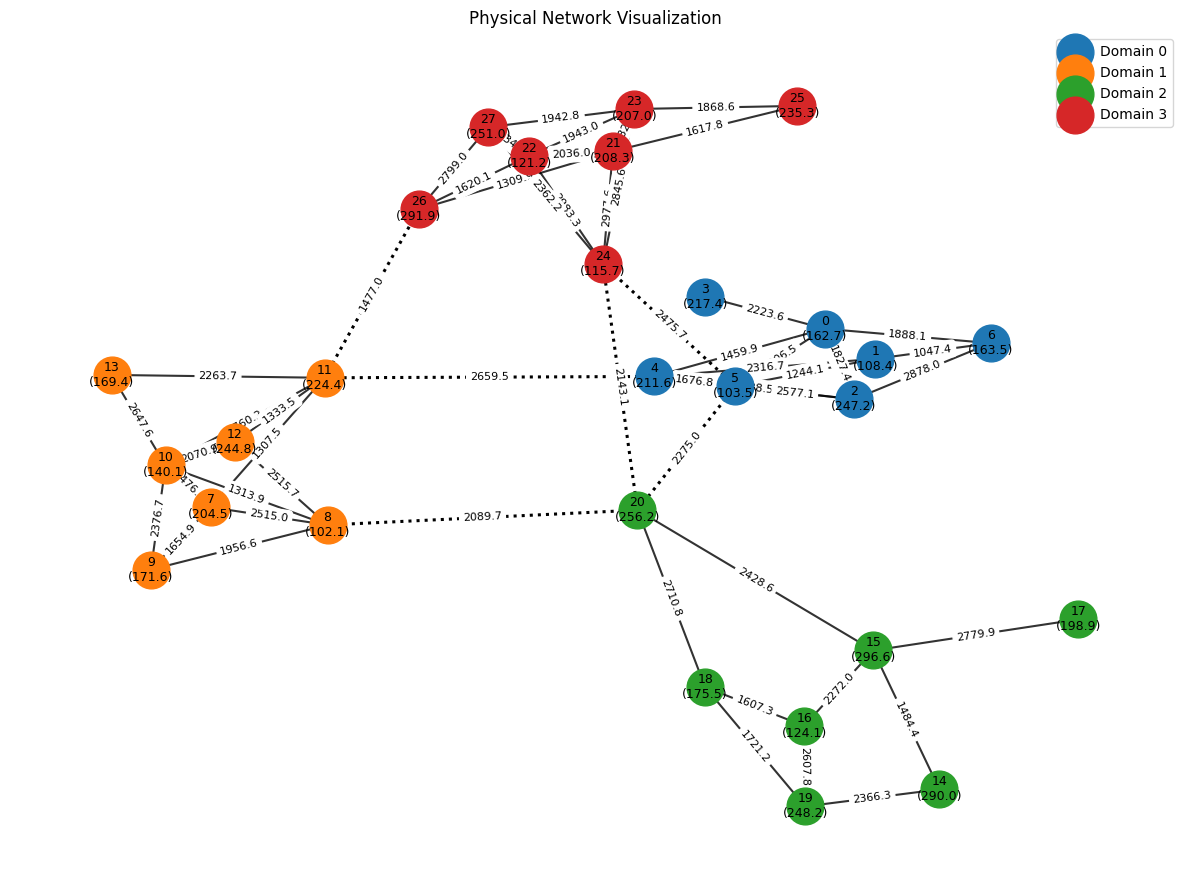

In [274]:
# Generate network
p_network = PhysicalNetwork.generator(
                num_domains=number_of_physical_network_domain, 
                nodes_per_domain=7,
                boundary_nodes_per_domain=2, 
                connection_rate=link_connection_rate
            )

visualize_physical_network(p_network)
mpvne = MP_VNE(p_network)

**Algorithm Execution**

In [275]:
import numpy as np
import heapq
import random

SIMULATION_TIME = 10000  
LAMBDA = 0.3             
LIFETIME_MEAN = 1000     
request_id = 0

current_time = 0
event_queue = [] 
active_requests = {}

total_request = 0
accept_request = 0
acceptance_rates = []
costs = []
delays = []
fail_reason = [0, 0]
living_request = []

print("Start")

def next_arrival_time():
    return np.random.exponential(1 / LAMBDA) 

while current_time < SIMULATION_TIME:
    living_request.append(len(event_queue))
    inter_arrival = next_arrival_time()
    arrival_time = current_time + inter_arrival
    if arrival_time > SIMULATION_TIME:
        break

    current_time = arrival_time
    request_id += 1
    total_request += 1

    v_network = VirtualNetwork.generator(
        num_nodes=number_of_request_nodes,
        connection_rate=0.5,
        number_of_domains=number_of_physical_network_domain
    )

    best_mapping = mpvne.map(v_network, request_id)
    if not best_mapping:
        fail_reason[0] += 1
        costs.append(costs[-1])
        delays.append(delays[-1])
        acceptance_rate = accept_request / total_request
        acceptance_rates.append(acceptance_rate)
        continue

    evaluator = PhysicalNetworkEvaluator(physical_network=p_network)
    mapping_cost = evaluator.evaluate_mapping_cost(best_mapping, v_network)

    if not mapping_cost:
        fail_reason[1] += 1
        costs.append(costs[-1])
        delays.append(delays[-1])
        acceptance_rate = accept_request / total_request
        acceptance_rates.append(acceptance_rate)
        continue

    cost, delay = mapping_cost
    costs.append(cost)
    delays.append(delay)
    accept_request += 1
    acceptance_rate = accept_request / total_request
    acceptance_rates.append(acceptance_rate)

    print(f"[t={current_time:.2f}] Request {request_id}: cost={cost:.3f}, delay={delay:.3f}, rate={acceptance_rate:.3f}")

    lifetime = np.random.exponential(LIFETIME_MEAN)
    expire_time = current_time + lifetime
    heapq.heappush(event_queue, (expire_time, "expire", request_id))
    active_requests[request_id] = best_mapping

    while event_queue and event_queue[0][0] <= current_time:
        _, event_type, rid = heapq.heappop(event_queue)
        if event_type == "expire" and rid in active_requests:
            mpvne.unmap(rid)
            del active_requests[rid]
            print(f"[t={current_time:.2f}] Request {rid} expired and unmapped.")

print("\nSimulation completed.")
print(f"Total requests: {total_request}, Accepted: {accept_request}, Acceptance rate: {accept_request / total_request:.3f}")
print(f"Failed reason: \n \tNot found solution: {fail_reason[0]}\n \tWrong Solution: {fail_reason[1]}")

Start
[t=0.43] Request 1: cost=128.254, delay=419.589, rate=1.000
[t=5.78] Request 2: cost=111.105, delay=468.403, rate=1.000
[t=20.67] Request 3: cost=134.255, delay=352.827, rate=1.000
[t=24.43] Request 4: cost=91.184, delay=246.969, rate=1.000
[t=28.66] Request 5: cost=129.627, delay=629.603, rate=1.000
[t=30.37] Request 6: cost=77.590, delay=368.445, rate=1.000
[t=41.45] Request 7: cost=147.392, delay=455.081, rate=1.000
[t=46.72] Request 8: cost=159.602, delay=541.742, rate=1.000
[t=51.65] Request 9: cost=103.054, delay=297.256, rate=1.000
[t=51.65] Request 7 expired and unmapped.
[t=62.75] Request 10: cost=71.463, delay=242.056, rate=1.000
[t=65.80] Request 11: cost=87.838, delay=409.137, rate=1.000
[t=66.62] Request 12: cost=136.727, delay=468.621, rate=1.000
[t=73.77] Request 13: cost=161.238, delay=432.316, rate=1.000
[t=75.03] Request 14: cost=124.694, delay=407.770, rate=1.000
[t=76.73] Request 15: cost=85.522, delay=294.739, rate=1.000
[t=77.53] Request 16: cost=173.999, de

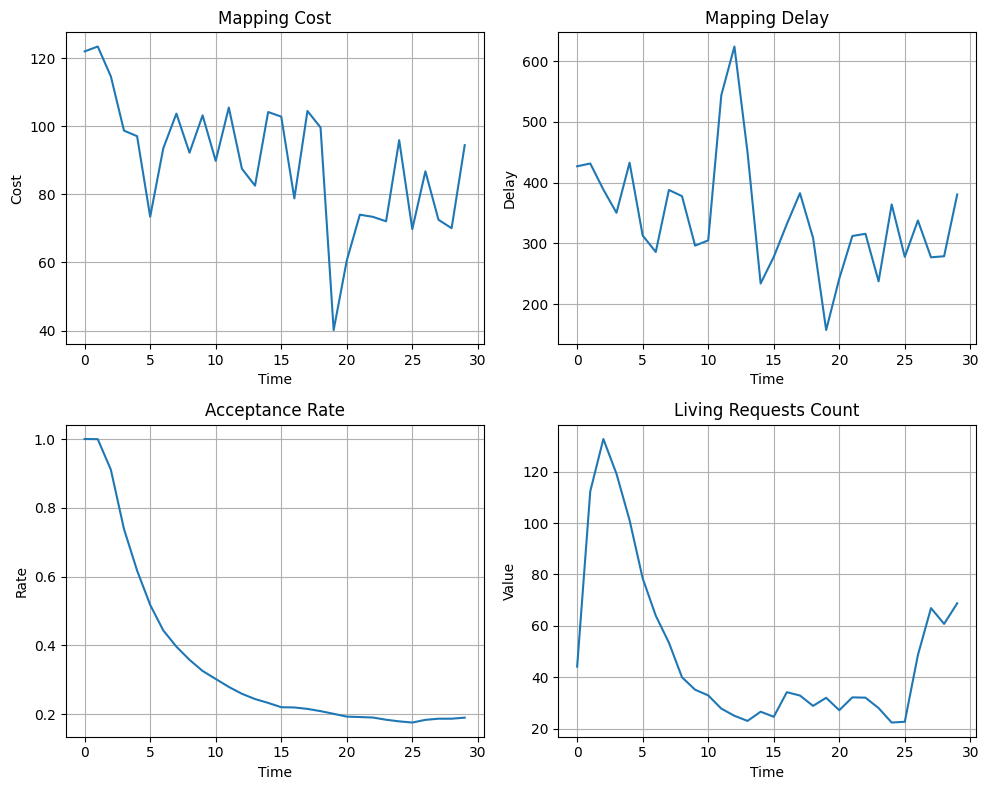

In [277]:
import numpy as np

def group_average(array, group_size=100):
    n = len(array)
    return [np.mean(array[i:i + group_size]) for i in range(0, n, group_size)]

grouped_costs = group_average(costs, 100)
grouped_delays = group_average(delays, 100)
grouped_acceptance = group_average(acceptance_rates, 100)
grouped_living_request = group_average(living_request, 100)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(grouped_costs)
axs[0, 0].set_title("Mapping Cost")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Cost")
axs[0, 0].grid(True)

axs[0, 1].plot(grouped_delays)
axs[0, 1].set_title("Mapping Delay")
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel("Delay")
axs[0, 1].grid(True)

axs[1, 0].plot(grouped_acceptance)
axs[1, 0].set_title("Acceptance Rate")
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Rate")
axs[1, 0].grid(True)

axs[1, 1].plot(grouped_living_request)
axs[1, 1].set_title("Living Requests Count")
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("Value")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()
